## Heart Stroke Prediction

### 0. Summary

#### Goal

Overall: To forecast the likelihood of a patient experiencing a stroke as a function of:
 - presence of diseases,
 - age,
 - gender,
 - smoking status,
 - etc.
 
 This part will focus on a relatively extensive "Exploratory Data Analysis" (EDA) of the Heart Stroke Prediction data set

#### Dataset

The data is a standard text file consisting of comma separated values, found in various places (for example [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)), with the following features:
 1. gender (object)
 2. age (float)
 3. hypertension (int)
 4. heart_disease (int)
 5. ever_married (object)
 6. work_type (object)
 7. Residence_type (object)
 8. avg_glucose (float)
 9. bmi (float)
 10. smoking_status (object)
 11. stroke (int)

There is a total of 5110 records.

---
### 1. Python Modules

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import pandas as pd
import seaborn as sns
import sklearn as skl 
import statsmodels.api as smapi
import scipy as scp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

---
### 2. Preprocess Data for EDA

In [7]:
df_raw = pd.read_csv("heart_stroke_prediction.csv")

Split the dataframe into 2 dataframes:
1. Numerical features
2. Categorical features
3. Boolean features

In [8]:
df_cat = df_raw[['gender','ever_married','work_type','Residence_type','smoking_status']].copy() # objects
df_num = df_raw[['age','avg_glucose_level','bmi',]].copy() # floats
df_int = df_raw[['hypertension','heart_disease','stroke']].copy() # ints (values are either 1 or 0)

#### Categorical dataframe

In [9]:
for col in df_cat.columns:
    print(col, df_cat[col].unique())

gender ['Male' 'Female' 'Other']
ever_married ['Yes' 'No']
work_type ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type ['Urban' 'Rural']
smoking_status ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


No phantom / duplicated categories. Normalize these categorical features by replacing dashes or spaces with underscores, and converting everything to lower case. 

In [10]:
# 1. get rid of spaces and replace dashes w. underscores
df_cat['work_type']      = df_cat['work_type'     ].replace('Self-employed',   'Self_employed')
df_cat['smoking_status'] = df_cat['smoking_status'].replace('formerly smoked', 'formerly_smoked')
df_cat['smoking_status'] = df_cat['smoking_status'].replace('never smoked',    'never_smoked')
# 2. turn all values to lower-case
for col in df_cat.columns:
    df_cat[col] = df_cat[col].map(lambda x:x.lower())
# 3. get rid of the capitalization in one of the columns
df_cat.columns = df_cat.columns.str.lower()

Find any count all NaN, None, NaT entries in the categorical dataframe. Count only `False` entries.

In [11]:
df_cat.isna().sum()

gender            0
ever_married      0
work_type         0
residence_type    0
smoking_status    0
dtype: int64

Find any wrong types among the entries.

In [12]:
for col in df_cat.columns:
    print(col, df_cat[col].apply(lambda x:isinstance(x,object)).value_counts().get(True))

gender 5110
ever_married 5110
work_type 5110
residence_type 5110
smoking_status 5110


#### Numerical dataframe

In [13]:
df_num.describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


* The values for `age` range from 0.08 (newborn) to 82, and there are no nonsensical values.
* Columns `hypertension`, `heart_disease`, and `stroke` are actually bool (not int64), expressed as either 1 or 0. Quantities such as the mean, the std, etc., are therefore meaningless for the purposes of this step.
* `avg_glucose_level` has a maximum of 271, which indicates a medical emergency, but which does not appear to be unreasonable.
* Similarly, the maximum `bmi` value (97.6) indicates a medically urgent scenario, but is nevertheless entirely plausible.

Find any count all NaN, None, NaT entries in the categorical dataframe

In [14]:
df_num.isna().sum()

age                    0
avg_glucose_level      0
bmi                  201
dtype: int64

Around 4% of the `bmi` feature are problematic. Replacing missing values with the `mean()` would be problematic due to the presence of outliers. So, replace with the median of the existing data set. This imputation is meant for the EDA steps ahead - different imputation techniques will be explored during the feature engineering stage.

In [15]:
median_bmi_val = df_num["bmi"].median()
df_num["bmi"] = df_num["bmi"].fillna(median_bmi_val)

In [16]:
df_num.isna().sum()

age                  0
avg_glucose_level    0
bmi                  0
dtype: int64

Next: check for out-of-place datatypes. Note that everything will evaluate to True if checked against the object datatype, but an int will evaluate to False if type checked against float.

In [17]:
cols_d = df_num.columns
for ii in range(0, len(cols_d), 1):
    print(df_num[cols_d[ii]].apply(lambda x:isinstance(x,(float))).value_counts().get(True))

5110
5110
5110


Reconstruct a new dataframe with the cleaned dataframes, include the original `id` feature.

In [18]:
df_new = pd.concat([df_raw['id'],df_num,df_cat,df_int], axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   age                5110 non-null   float64
 2   avg_glucose_level  5110 non-null   float64
 3   bmi                5110 non-null   float64
 4   gender             5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   smoking_status     5110 non-null   object 
 9   hypertension       5110 non-null   int64  
 10  heart_disease      5110 non-null   int64  
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Check for duplicated records in the full *new* dataframe

In [19]:
print(df_new.duplicated().sum())

0


In [20]:
df_new

,id,age,avg_glucose_level,bmi,gender,ever_married,work_type,residence_type,smoking_status,hypertension,heart_disease,stroke
0,9046,67.0,228.69,36.6,male,yes,private,urban,formerly_smoked,0,1,1
1,51676,61.0,202.21,28.1,female,yes,self_employed,rural,never_smoked,0,0,1
2,31112,80.0,105.92,32.5,male,yes,private,rural,never_smoked,0,1,1
3,60182,49.0,171.23,34.4,female,yes,private,urban,smokes,0,0,1
4,1665,79.0,174.12,24.0,female,yes,self_employed,rural,never_smoked,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,83.75,28.1,female,yes,private,urban,never_smoked,1,0,0
5106,44873,81.0,125.20,40.0,female,yes,self_employed,urban,never_smoked,0,0,0
5107,19723,35.0,82.99,30.6,female,yes,self_employed,rural,never_smoked,0,0,0
5108,37544,51.0,166.29,25.6,male,yes,private,rural,formerly_smoked,0,0,0


---
### 3. Exploratory Data Analysis - Univariate

In [35]:
def plot_kde(
        df_input: pd.Series,
        grid_len: int,
        lim_x: list[float],
        lim_y: list[float],
        data_spread: list[float],
        lbl_mean: list[float],
        lbl_median: list[float],
        title: str,
        ylabl: str,
        xlabl: str,
    ):
    # -------------------------------------------------------------------------
    data_kde = df_input.to_numpy()
    grid_kde = np.linspace(lim_x[0], lim_x[1], grid_len)
    dens_kde = scp.stats.gaussian_kde(data_kde)(grid_kde)
    val_mean = np.mean(data_kde)
    val_medn = np.median(data_kde)
    # -------------------------------------------------------------------------
    fig, axs = plt.subplots(figsize=(6,3))
    axs.plot(
        grid_kde,
        dens_kde,
        color='blue',
        lw=1,
        linestyle='-'
    )
    axs.plot(
        data_kde,
        data_spread[0] + data_spread[1] * np.random.random(data_kde.shape[0]),
        '.',
        color='darkgray',
        alpha=0.1
    )
    axs.axvline(
        ymin=0.000,
        ymax=1.000,
        x=np.mean(data_kde),
        lw=0.5,
        color='red',
        label='mean'
    )
    axs.axvline(
        ymin=0.000,
        ymax=1.00,
        x=np.median(data_kde),
        lw=0.5,
        color='blue',
        label='mean'
    )
    axs.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True
    )
    axs.set_ylim(
        lim_y[0],
        lim_y[1]
    )
    axs.set_ylabel(ylabl)
    axs.set_xlabel(xlabl)
    axs.set_title(title)
    axs.text(
        val_mean+lbl_mean[0],
        lbl_mean[1], 
        f'mean={val_mean:.1f}'
    )
    axs.text(
        val_medn+lbl_median[0],
        lbl_median[1],
        f'median={val_medn:.1f}'
    )
    fig.tight_layout()
    return

In [36]:
def plot_qq(
        df_input: pd.Series,
        title: str,
    ):
    fig, axs = plt.subplots(figsize=(5,3))
    marker_opts = {
        'marker':'o',
        'markersize':1,
        'markerfacecolor':'black',
        'markeredgecolor':'black',
        'alpha':0.5,
    }
    smapi.qqplot(
        df_input,
        line='45',
        ax=axs,
        **marker_opts
    )
    axs.get_lines()[1].set_color('blue')
    axs.get_lines()[1].set_linewidth(1)
    axs.set_title(title)
    axs.set_xlim(-3.5,4)
    axs.tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True
    )
    return

In [23]:
def plot_count_pie(
        df_input: pd.DataFrame,
        palette: str,
        colormap: str,
        feature: str,
        width: float
    ):
    fig, axs = plt.subplots(
        ncols=2,
        figsize=(10,3)
    )
    sns.countplot(
        x=feature,
        data=df_input,
        ax=axs[0],
        palette=palette,
        width=width
    )
    df_input[feature].value_counts(ascending=True).plot(
        kind="pie",
        autopct="%.2f",
        ax=axs[1],
        cmap=colormap,
        ylabel=''
    )
    axs[0].tick_params(
        axis='both',
        direction='in',
        top=True,
        right=True
    )
    fig.tight_layout()
    return

#### Numerical Features

* Kernel Density Estimation.
* Quantile-Quantile (Q-Q) plots.
* Collinearity checks.

Kernel Density Estimation:

In [25]:
data_age = df_new['age']
data_agl = df_new['avg_glucose_level']
data_bmi = df_new['bmi']

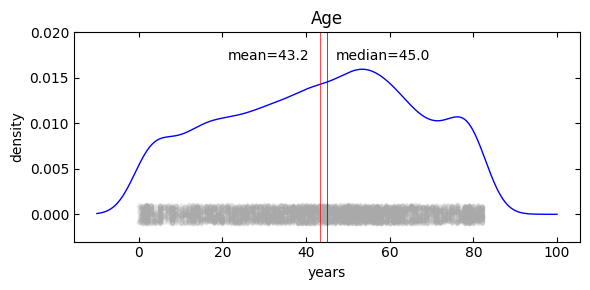

In [26]:
# Kernel Density Estimation: Age
plot_kde(data_age,1000,[-10, 100],[-0.003, 0.02],[-0.001,0.0020],[-22,0.017],[2,0.017],'Age','density','years')

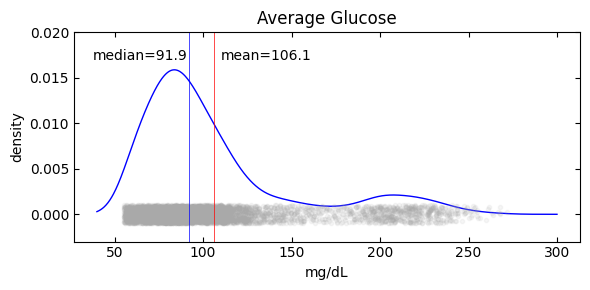

In [27]:
# Kernel Density Estimation: Average Glucose Level
plot_kde(data_agl,1000,[40,300],[-0.003,0.02],[-0.001,0.0020],[4,0.017],[-54,0.017],'Average Glucose','density','mg/dL')

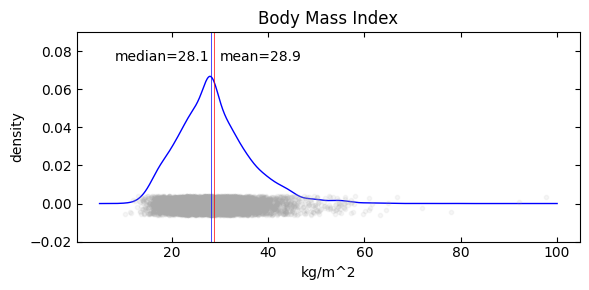

In [28]:
# Kernel Density Estimation: Body Mass Index
plot_kde(data_bmi,1000,[ 5,100],[-0.020,0.09],[-0.006,0.0100],[1,0.075],[-20,0.075],'Body Mass Index','density','kg/m^2')

Q-Q Plots

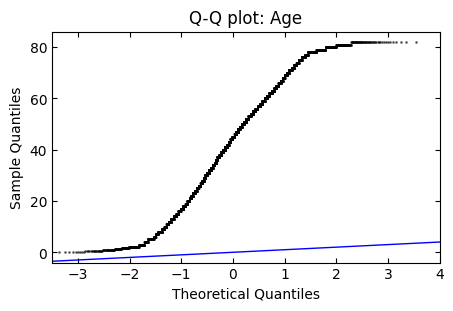

In [37]:
plot_qq(data_age,'Q-Q plot: Age')

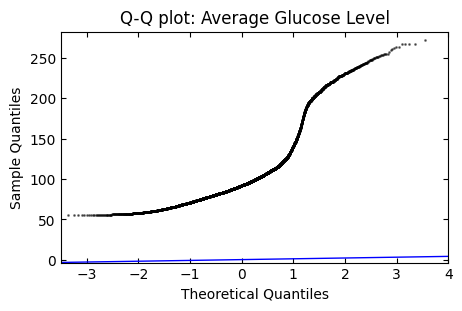

In [38]:
plot_qq(data_agl,'Q-Q plot: Average Glucose Level')

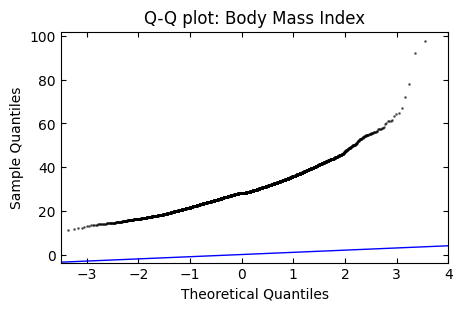

In [39]:
plot_qq(data_bmi,'Q-Q plot: Body Mass Index')

Collinearity checks

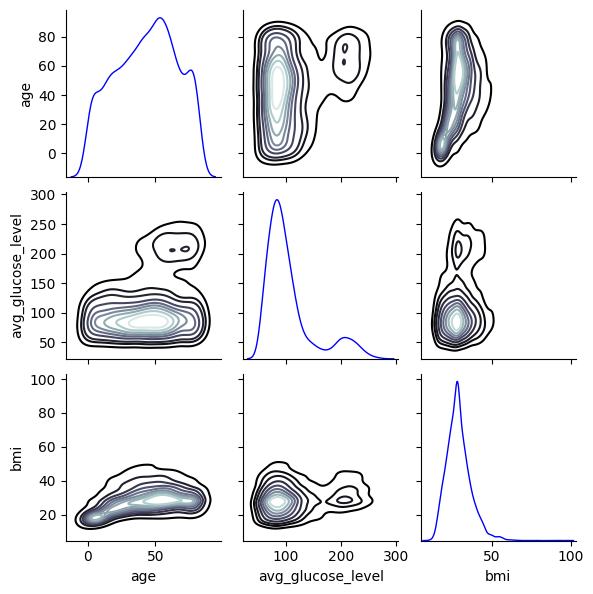

In [40]:
# pairplot is visual-intuitive
sns.pairplot(
    df_num,kind='kde',
    palette='ch:start=.2,r=-.2',
    diag_kws={'color':'blue','fill':False,'linewidth':1},
    plot_kws={'cmap':'bone'},
    height=2
)

<Axes: >

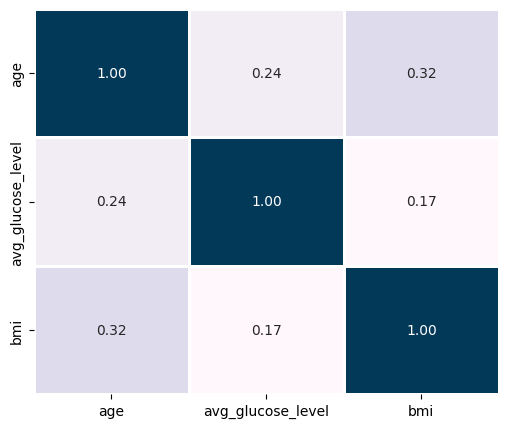

In [41]:
# heatmaps are more quantitative than pairplots
fig = plt.gcf()
fig.set_size_inches(6,5)
sns.heatmap(
    df_num.corr(),
    annot=True,
    fmt='.2f',
    linewidth=0.75,
    cmap='PuBu',
    cbar=False
)

#### Categorical Features

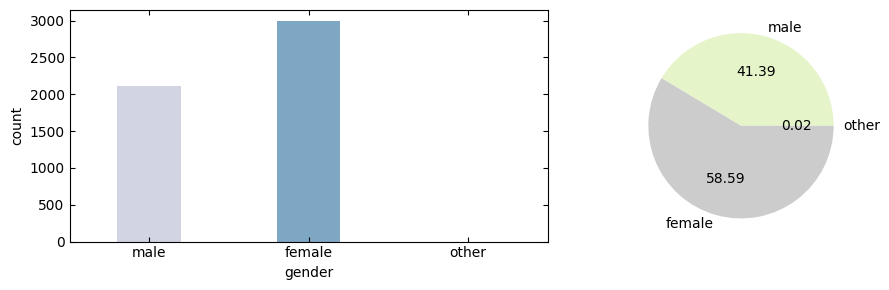

In [42]:
plot_count_pie(df_cat,'PuBu','Pastel2','gender',0.40)

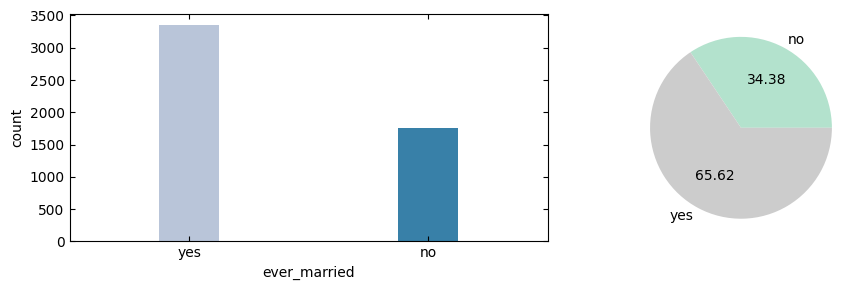

In [43]:
plot_count_pie(df_cat,'PuBu','Pastel2','ever_married',0.25)

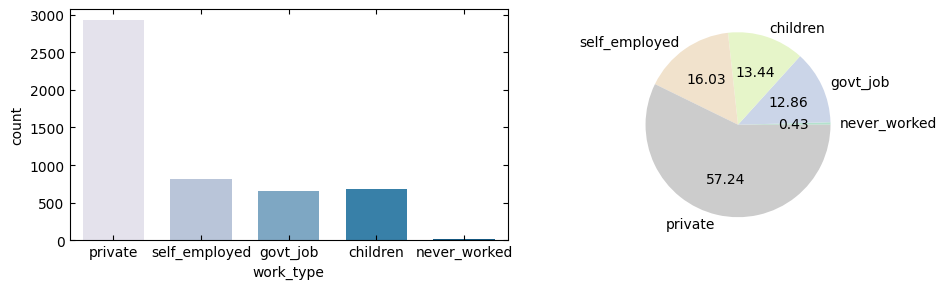

In [44]:
plot_count_pie(df_cat,'PuBu','Pastel2','work_type',0.70)

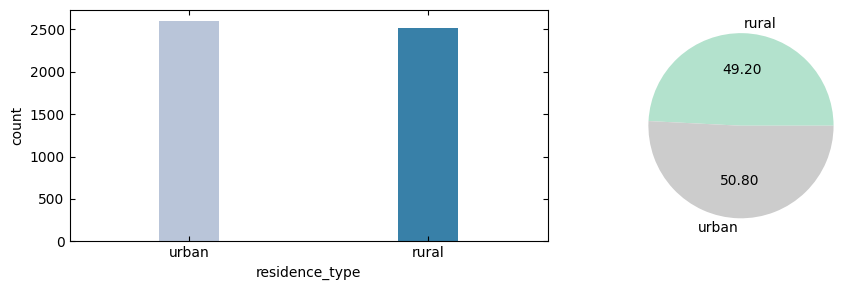

In [45]:
plot_count_pie(df_cat,'PuBu','Pastel2','residence_type',0.25)

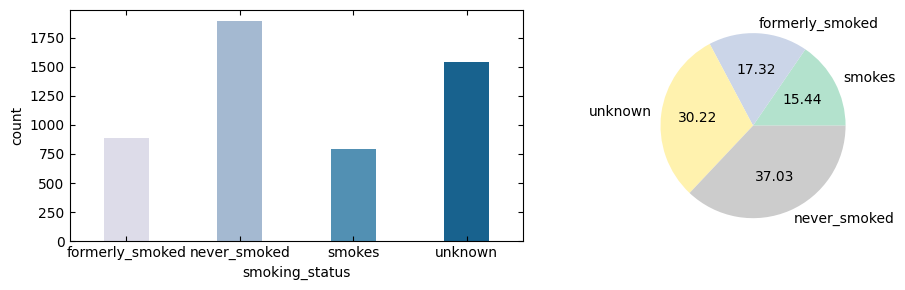

In [46]:
plot_count_pie(df_cat,'PuBu','Pastel2','smoking_status',0.40)

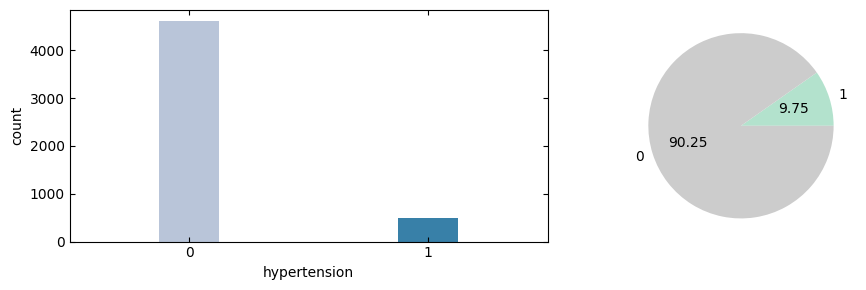

In [47]:
plot_count_pie(df_int,'PuBu','Pastel2','hypertension',0.25)

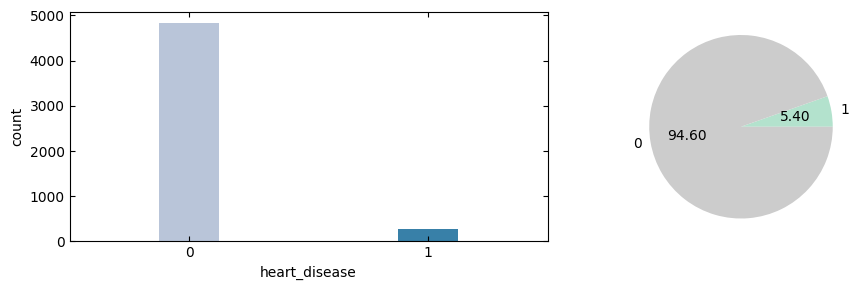

In [48]:
plot_count_pie(df_int,'PuBu','Pastel2','heart_disease',0.25)

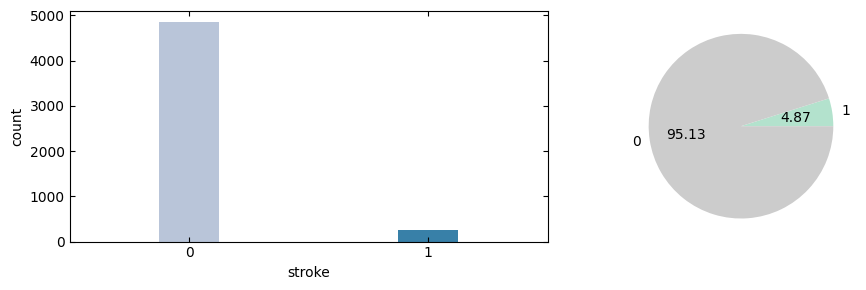

In [49]:
plot_count_pie(df_int,'PuBu','Pastel2','stroke',0.25)

---
### 4. Exploratory Data Analysis - Bivariate

Explore the relationships between data pairs: the target variable, stroke incidence, and the rest of the set.
* Generate FacetGrid plots w/ KDE based on stroke incidence per independent parameter.
* Construct a helper function `t_test_ind` that determines if the difference between categories is meaningful
* Label encode all the categorical features
* Simple countplots and p-value determinations.

In [50]:
def t_test_ind(
        df_full: pd.DataFrame,
        col_0: str,
        col_1: str
    ):
    """
    Calculates t-statistic and p-value for two independent samples
    Args:
        df_full (pd.DataFrame): Dataframe containing the features needed
        col_0  (str)          : target feature, found in df_full
        col_1  (str)          : tested feature, found in df_full.
    Returns:
        tuple: (t_statistic, p_value)
    """
    uniques = df_full[col_1].unique()
    # note: a KDE plot of set_0 & set_1 would be identical to the
    # sns.FacetGrid plots displayed in the cells below this one
    set_0 = df_full[col_0][df_full[col_1] == uniques[0]]
    set_1 = df_full[col_0][df_full[col_1] == uniques[1]]
    t_stat, p_value = scp.stats.ttest_ind(set_0,set_1)
    return t_stat, p_value

In [51]:
df_num = df_new[['age','avg_glucose_level','bmi','stroke']].copy()
df_cat = df_new[['gender','hypertension','heart_disease','ever_married','work_type','residence_type','smoking_status','stroke']].copy()

In [52]:
df_cat['gender_enc']         = skl.preprocessing.LabelEncoder().fit_transform(df_new['gender'])
df_cat['hypertension_enc']   = skl.preprocessing.LabelEncoder().fit_transform(df_new['hypertension'])
df_cat['heart_disease_enc']  = skl.preprocessing.LabelEncoder().fit_transform(df_new['heart_disease'])
df_cat['ever_married_enc']   = skl.preprocessing.LabelEncoder().fit_transform(df_new['ever_married'])
df_cat['work_type_enc']      = skl.preprocessing.LabelEncoder().fit_transform(df_new['work_type'])
df_cat['residence_type_enc'] = skl.preprocessing.LabelEncoder().fit_transform(df_new['residence_type'])
df_cat['smoking_status_enc'] = skl.preprocessing.LabelEncoder().fit_transform(df_new['smoking_status'])

#### stroke & age

In [53]:
tstat, p_val = t_test_ind(df_num,'stroke','age')
print(f"t-statistic : {tstat:7.3f}")
print(f"p-value     : {p_val:7.3f}")

t-statistic :  -0.371
p-value     :   0.711


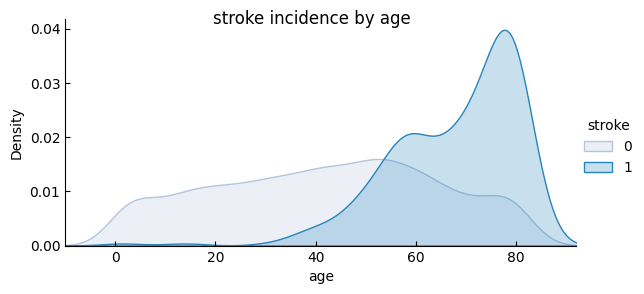

In [55]:
facet_plot = sns.FacetGrid(df_num,hue='stroke',palette='PuBu',aspect=2)\
    .map(sns.kdeplot,'age',shade=True,)\
    .set(xlim=(-10,df_num['age'].max()+10))\
    .add_legend()\
    .tick_params(axis='both',direction='in',top=False,right=False)\
    .figure.suptitle('stroke incidence by age')

#### stroke & average glucose level

In [56]:
tstat, p_val = t_test_ind(df_num,'stroke','bmi')
print(f"t-statistic : {tstat:7.3f}")
print(f"p-value     : {p_val:7.3f}")

t-statistic :  -1.058
p-value     :   0.291


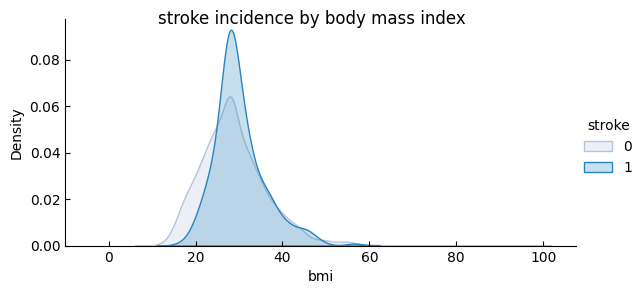

In [57]:
facet_plot = sns.FacetGrid(df_num,hue='stroke',palette='PuBu',aspect=2)\
    .map(sns.kdeplot,'bmi',shade=True)\
    .set(xlim=(-10,df_num['bmi'].max()+10))\
    .add_legend()\
    .tick_params(axis='both',direction='in',top=False,right=False)\
    .figure.suptitle('stroke incidence by body mass index')

#### stroke & gender

In [58]:
tstat, p_val = t_test_ind(df_cat,'stroke','gender_enc')
print(f"t-statistic : {tstat:7.3f}")
print(f"p-value     : {p_val:7.3f}")

t-statistic :   0.649
p-value     :   0.516


stroke              0         1
gender_enc                     
0           55.831703  2.759295
1           39.275930  2.113503
2            0.019569  0.000000


Text(0.5, 1.0, 'stroke incidence vs. gender')

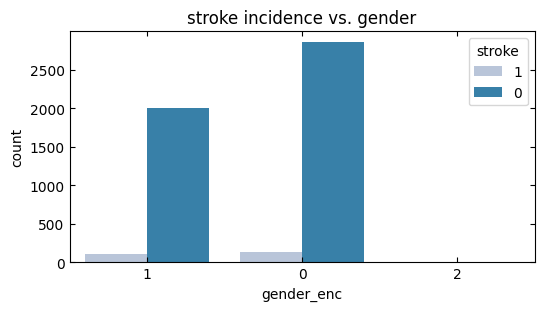

In [59]:
print(pd.crosstab(df_cat["gender_enc"], df_cat["stroke"], normalize=True) * 100)
fig, axs = plt.subplots(figsize=(6,3))
sns.countplot(x=df_cat['gender_enc'].astype('str'),hue=df_cat['stroke'].astype('str'),palette='PuBu')
axs.tick_params(axis='both',direction='in',top=True,right=True)
axs.set_title('stroke incidence vs. gender')

#### stroke & hypertension

In [60]:
tstat, pval = t_test_ind(df_cat,'stroke','hypertension_enc')
print('t-statistic        : ', tstat)
print('p-value            : ', pval)

t-statistic        :  -9.217024582800926
p-value            :  4.367556769973551e-20


stroke                    0         1
hypertension_enc                     
0                 86.673190  3.581213
1                  8.454012  1.291585


Text(0.5, 1.0, 'stroke incidence vs. hypertension')

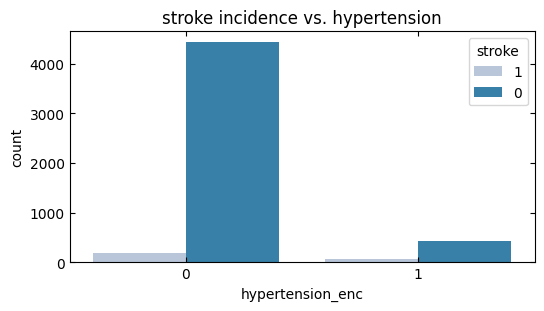

In [61]:
print(pd.crosstab(df_cat["hypertension_enc"], df_cat["stroke"], normalize=True) * 100)
fig, axs = plt.subplots(figsize=(6,3))
sns.countplot(x=df_cat['hypertension_enc'].astype('str'),hue=df_cat['stroke'].astype('str'),palette='PuBu')
axs.tick_params(axis='both',direction='in',top=True,right=True)
axs.set_title('stroke incidence vs. hypertension')

#### stroke & heart_disease

In [62]:
tstat, pval = t_test_ind(df_cat,'stroke','heart_disease_enc')
print('t-statistic        : ', tstat)
print('p-value            : ', pval)

t-statistic        :  9.731310601166047
p-value            :  3.451927371748839e-22


stroke                     0         1
heart_disease_enc                     
0                  90.645793  3.953033
1                   4.481409  0.919765


Text(0.5, 1.0, 'stroke incidence vs. heart_disease')

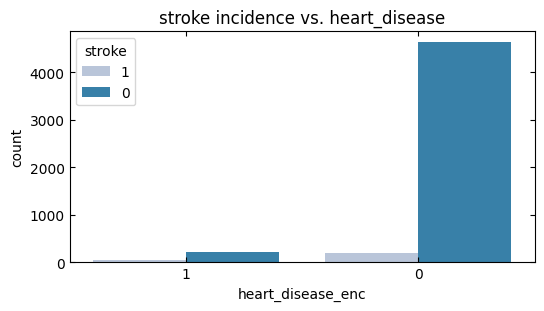

In [63]:
print(pd.crosstab(df_cat["heart_disease_enc"], df_cat["stroke"], normalize=True) * 100)
fig, axs = plt.subplots(figsize=(6,3))
sns.countplot(x=df_cat['heart_disease_enc'].astype('str'),hue=df_cat['stroke'].astype('str'),palette='PuBu')
axs.tick_params(axis='both',direction='in',top=True,right=True)
axs.set_title('stroke incidence vs. heart_disease')